# 非参数检验（第二部分）

到目前为止，你在设计和分析实验时，对正态分布的均值采用的都是标准假设检验。但是，有时候不能只依赖于标准检验。原因可能是不确定指标分布的真实变化性、缺少满足正态要求的数据，或者想对缺少标准检验的统计量进行推理。这时候就有必要了解一些非参数检验，不仅仅是为了处理上述情况，而且可以作为实验结果的辅助检查工具。

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
% matplotlib inline

## 秩和检验（曼-惠特尼检验）

秩和检验与之前的两个方法差别很大。不需要重新抽样，仅对存在的数据进行检验。秩和检验又称为曼-惠特尼 U 检验，它并不检验特定的统计量，例如均值或中值。而是检验分布：假设我们随机地从每个小组的总体中抽取一个值。零假设表示更大的值来自第一个小组的概率与来自第二个小组的概率一样；备择假设表示这两个概率不相同，可以表示为单尾或双尾检验。

为了检验这种假设，我们应该查看收集的数据，并看看在多少情形下一个小组的值大于另一个小组的值。即对于第一个小组中的每个数据点，我们都数数第二个小组里有多少值小于它。（如果两个值相等，则表示打成平手，使计数器加 0.5。）第一组获胜的数量用值 $U$ 表示。

如果样本量足够大的话，则 $U$ 大致呈正态分布。如果第一组有 $n_1$ 个数据点，第二组有 $n_2$ 个数据点，那么总共有 $n_1 n_2$ 次比对和同等数量的获胜点。在零假设下，获胜次数在两组之间的分布应该是均匀的，所以预期的获胜次数为 $\mu_U = \frac{n_1 n_2}{2}$。获胜次数的可变性可以用以下方程表示（假设没有平局或只有少数几个平局）：

$$ 
\sigma_U = \sqrt{\frac{n_1n_2(n_1+n_2+1)}{12}}
$$

$\mu_U$ 和 $\sigma_U$ 值然后可以用来计算标准正态 z 分数，进而生成 p 值。请在以下单元格中实现秩和检验方法。

- 提示：计算 z 分数后，可以使用 scipy stats 的[`norm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) 类获取 p 值。

In [7]:
def ranked_sum(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute U
    u = 0
    for i in x:
        wins = (i > y).sum()
        ties = (i == y).sum()
        u += wins + 0.5 * ties
    
    # compute a z-score
    n_1 = x.shape[0]
    n_2 = y.shape[0]
    mean_u = n_1 * n_2 / 2
    sd_u = np.sqrt( n_1 * n_2 * (n_1 + n_2 + 1) / 12 )
    z = (u - mean_u) / sd_u
    
    # compute a p-value
    if alternative == 'two-sided':
        p = 2 * stats.norm.cdf(-np.abs(z))
    if alternative == 'less':
        p = stats.norm.cdf(z)
    elif alternative == 'greater':
        p = stats.norm.cdf(-z)
    
    return p

In [4]:
data = pd.read_csv('data/permutation_data.csv')
data.head(10)

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928
5,0,3791
6,0,736
7,1,8482
8,0,4594
9,0,1171


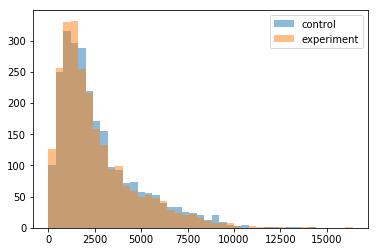

In [5]:
# data visualization
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [8]:
ranked_sum(data[data['condition'] == 0]['time'],
           data[data['condition'] == 1]['time'],
           alternative = 'greater')

(0.0017522265022961059, 3273546.0)

### 秩和检验注意事项

如果样本量更小，可以进行置换检验。在检查某个值的所有可能小组标签分配的获胜分布后，可以计算 p 值并判断实际观察到的 $U$ 有多不寻常。

此外，scipy stats 软件包中已经有一个函数 [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 能够执行曼惠特尼 U 检验。此函数考虑的因素比上述实现要多，包括对平局的标准差进行校正，以及连续校正（因为我们通过连续分布逼近离散值分布）。此外，他们采取的方法计算更高效，基于的是秩和（因而得名秩和检验），而不是上面解释的比对方法。

参考资料：[维基百科文章](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)

In [9]:
stats.mannwhitneyu(data[data['condition'] == 0]['time'],
                   data[data['condition'] == 1]['time'],
                   alternative = 'greater')

MannwhitneyuResult(statistic=3273546.0, pvalue=0.0017522802260045969)

## 符号检验

符号检验也仅使用收集的数据计算检验结果。只需两组之间有可比较的配对值，并且一组的值一般比另一组的要大。

在符号检验中，我们不关心两组之间的差异有多大，只关心哪组的值更大。所以 0.21 与 0.22 比较和 0.21 与 0.31 比较都表示第二组的值更大。这就导致符号检验是一个不太可靠的检验，虽然可以广泛应用。如果可以从中抽样的观察值太少，并且无法对底层的分布特征做出很好的假设，那么这种检验最有用。例如，可以使用符号检验进一步检查日常汇总的点击率。

特定组的获胜次数可以用二项分布表示。在零假设下，任何一组有更大值的概率是一样的（如果是平局，则不比较）：二项分布的成功参数是 $p = 0.5$。请在下面的函数中实现符号检验。

- 提示：计算比对和获胜次数后，可以使用 scipy stats 的 [`binom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) 类获取 p 值。

In [ ]:
def sign_test(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute parameters
    n = x.shape[0] - (x == y).sum()
    k = (x > y).sum() - (x == y).sum()

    # compute a p-value
    if alternative == 'two-sided':
        p = min(1, 2 * stats.binom(n, 0.5).cdf(min(k, n-k)))
    if alternative == 'less':
        p = stats.binom(n, 0.5).cdf(k)
    elif alternative == 'greater':
        p = stats.binom(n, 0.5).cdf(n-k)
    
    return p

In [ ]:
data = pd.read_csv('data/signtest_data.csv')
data.head()

In [ ]:
# data visualization
plt.plot(data['day'], data['control'])
plt.plot(data['day'], data['exp'])
plt.legend()

plt.xlabel('Day of Experiment')
plt.ylabel('Success rate');

In [ ]:
sign_test(data['control'], data['exp'], 'less')

```python

```